<a href="https://colab.research.google.com/github/pharringtonp19/jmp_paper/blob/main/notebooks/gradient_descent_motivating_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title  { form-width: "1%", display-mode: "form" }
%%capture 
!pip install flax
!pip install optax
!pip install tree-math
!pip install diffrax

In [2]:
from jax import random, vmap
import jax
import jax.numpy as jnp
import tree_math as tm 
import flax
from typing import Sequence # Used to define Flax Model
import flax.linen as nn     # Used to define Flax Model
import optax                # Neural Network Optimizer
from optax import set_to_zero 
import math
from functools import partial
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt, PIDController, Dopri8, Kvaerno5, Heun, NoAdjoint
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
min_obs, max_obs, n_cohorts, eps, n_epochs = 10, 50, 6, 1.5, 1000
key_num = 18
key = jax.random.PRNGKey(key_num)

In [4]:
def main_effect(x):
  return jnp.log(x**2 + 1.0 + jnp.sin(x*3)) + 1.5

def gen_functions(key, x, i):
  key, subkey = jax.random.split(key)
  weights = random.normal(subkey, shape=(4,))
  y = main_effect(x) #weights[0] + weights[1]*x + weights[2] * jnp.sin(x)
  y = y - jnp.mean(y) # Normalize within Cluster
  plt.scatter(x, y, label=i+1)
  return y 

def gen_samples(key, min_obs, max_obs, n_cohorts, eps):
  d = {}
  fig = plt.figure(dpi=300, tight_layout=True, figsize=(6.4, 4.8))
  for i in range(n_cohorts):
    key, subkey = jax.random.split(key)
    n_obs = jax.random.choice(subkey, max_obs-min_obs ) + min_obs
    x_mean = random.normal(key, shape=(1,))
    x = jnp.linspace(x_mean - eps, x_mean + eps, n_obs) 
    y = gen_functions(key, x, i)
    d[i] = jnp.hstack((x, y))
  plt.legend(title=r'$E[Y|C=i]$', ncol=2, fontsize='xx-small')
  plt.title(r'$Y$', loc='left')
  plt.xlabel(r'$X$')
  fig.savefig('motivating_cefs.pdf', format='pdf')
  plt.show()
  return d

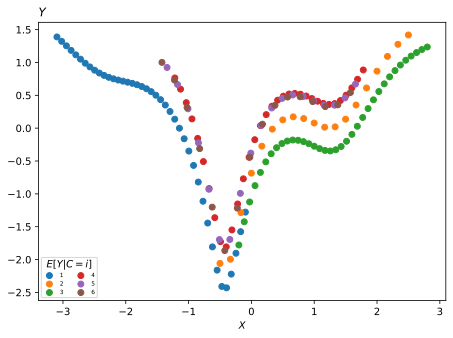

In [5]:
data = gen_samples(key, min_obs, max_obs, n_cohorts, eps)


In [6]:
class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact 
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x 

def init_fn(seed):

  # Initialize Model
  rng = random.PRNGKey(seed)
  params = flax.core.unfreeze(model.init(rng, jnp.ones((1, 1))))['params']
  
  return params

In [7]:
def maml_loss_fn(params, n_inner_epochs, data):

  inputs, targets = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
  def update(carry, t):
    params, opt_state = carry 
    loss, grads = jax.value_and_grad(loss_fn)(params, inputs, targets)
    updates, opt_state = inner_gradient_processor.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return (params, opt_state), (loss)
  (opt_params, _), _ = jax.lax.scan(update, (params, inner_gradient_processor.init(params)), None, length=n_inner_epochs)
  return loss_fn(opt_params, inputs, targets)

@partial(jax.jit, static_argnums=1)
def avg_mamal(params, inner_epochs, data):
  return (1/n_cohorts)*(jax.tree_util.tree_reduce(lambda x, y: x + y, jax.tree_map(partial(maml_loss_fn, params, inner_epochs), data)))

def pytree_loss(params, data):
  inputs, targets = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
  return loss_fn(params, inputs, targets)

def loss_fn(params, inputs, targets):    
    predictions = model.apply({"params": params}, inputs)
    return jnp.mean((targets - predictions)**2)

def avg_loss_fn(params, data):
  return (1/n_cohorts)*(jax.tree_util.tree_reduce(lambda x, y: x + y, jax.tree_map(partial(pytree_loss, params), data)))

def weighted_loss(params, weight, n_inner_epochs, data):
  a = avg_mamal(params, n_inner_epochs, data)
  b = avg_loss_fn(params, data)
  loss = jnp.where(weight == 0., b, jnp.where(weight == 1., a, weight*a + (1-weight)*b))
  return loss

In [8]:
#@title  { form-width: "1%", display-mode: "form" }
@partial(jax.jit, static_argnums=(1,2,3))
def train(params, epochs, weight, inner_epochs, data):

  def update(carry, t):
    params, opt_state = carry 
    loss, grads = jax.value_and_grad(weighted_loss)(params, weight, inner_epochs, data)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return (params, opt_state), (loss)
  (opt_params, _), losses = jax.lax.scan(update, (params, opt.init(params)), None, length=n_epochs)
  return opt_params# , losses

In [9]:
layers = [32, 32, 1]
layer_freeze = [True, True, False]
int_layer_freeze = map(int, layer_freeze)
epochs = 1000
inner_epochs = 3
weight = 0.9
model = MLP(layers)
params = init_fn(0)
opt = optax.sgd(learning_rate=0.01, momentum=0.9)
inner_gradient_processor = optax.multi_transform({"train":optax.sgd(learning_rate=0.001), "zero": set_to_zero()},
                          {f"Dense_{i}": "zero" if j else "train" for (i, j) in enumerate(layer_freeze)})

In [10]:
single_opt_params = train(params, epochs, weight, 3, data) 

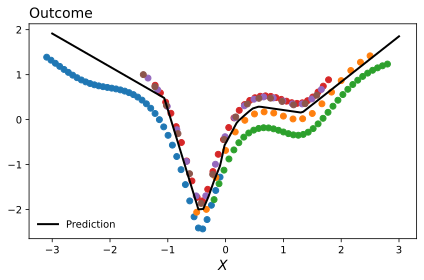

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=300, tight_layout=True)
xs = jnp.linspace(-3., 3., 1000).reshape(-1,1)
ax.plot(xs, model.apply({"params": single_opt_params}, xs),linewidth=2 , color='black', label='Prediction')
for i in range(n_cohorts):
  ax.scatter(data[i][:,0], data[i][:,1])
plt.xlabel(r'$X$', size=14)
plt.title('Outcome', loc='left', size=14)
plt.legend(frameon=False)
fig.savefig('gradient_descent_motivating_example.pdf', format='pdf')
fig.savefig('gradient_descent_motivating_example.png', format='png')
plt.show()

In [12]:
v = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1.]
opt_params = jax.tree_map(lambda a: train(params, epochs, a, inner_epochs, data),v)

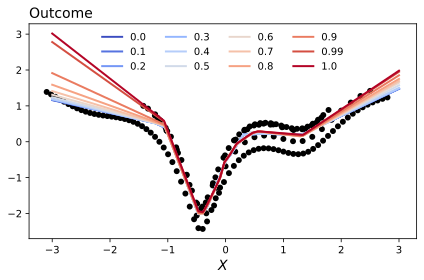

In [13]:
colormap = plt.cm.coolwarm
colors = [colormap(i) for i in jnp.linspace(0, 1,12)]

fig, ax = plt.subplots(nrows=1, ncols=1, dpi=300, tight_layout=True)
ax.set_prop_cycle('color', colors)
xs = jnp.linspace(-3., 3., 1000).reshape(-1,1)
for i in range(n_cohorts):
  ax.scatter(data[i][:,0], data[i][:,1], color='black', edgecolor="none")
for i in range(len(opt_params)):
  ax.plot(xs, model.apply({"params": opt_params[i]}, xs),linewidth=2, label=v[i])
plt.xlabel(r'$X$', size=14)
plt.title('Outcome', loc='left', size=14)
plt.legend(frameon=False, ncol=4)
fig.savefig('gradient_descent_motivating_example_tune.pdf', format='pdf')
fig.savefig('gradient_descent_motivating_example_tune.png', format='png')
plt.show()